In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import cv2
import glob
import random
from PIL import Image
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet152V2, VGG16, VGG19, InceptionV3, EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score, recall_score, precision_score, f1_score
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import keras.backend as K

In [2]:
import sys
import os

code_folder = r'D:/Corrosion detection/Corrosion Detection/Code'
sys.path.append(code_folder)

from ImageProcessor import ImageReader, ImageLoading,ImageAugmentation
from Model import ModelTrainer,ModelArchitectures 

In [3]:
train_1st_path = 'D:/Corrosion detection/Corrosion Detection/Dataset/Training/1st'
test_1st_path = 'D:/Corrosion detection/Corrosion Detection/Dataset/Testing/1st'
pred_path = 'D:/Corrosion detection/Corrosion Detection/Dataset/Pred'
train_2nd_path = 'D:/Corrosion detection/Corrosion Detection/Dataset/Training/2nd'
test_2nd_path = 'D:/Corrosion detection/Corrosion Detection/Dataset/Testing/2nd'
augmented_train_1st_path = 'D:/Corrosion detection/Corrosion Detection/Dataset/Augmented_Training/1st'
augmented_train_2nd_path = 'D:/Corrosion detection/Corrosion Detection/Dataset/Augmented_Training/2nd'

In [4]:
# Initialize ImageReader instances
image_reader_1st_train = ImageReader(train_1st_path)
image_reader_1st_test = ImageReader(test_1st_path)
image_reader_1st_pred = ImageReader(pred_path)
image_reader_2nd_train = ImageReader(train_2nd_path)
image_reader_2nd_test = ImageReader(test_2nd_path)

# Count images in folders for each set (1st and 2nd datasets)
image_reader_1st_train.count_images_in_folders('training', is_subfolder=True)
image_reader_1st_test.count_images_in_folders('testing', is_subfolder=True)
image_reader_1st_pred.count_images_in_folders('prediction', is_subfolder=False)

image_reader_2nd_train.count_images_in_folders('training', is_subfolder=True)
image_reader_2nd_test.count_images_in_folders('testing', is_subfolder=True)

# Get image sizes for each dataset (1st and 2nd datasets)
print("Image sizes for 1st Training Dataset:")
print(image_reader_1st_train.get_image_sizes(is_subfolder=True))

print("Image sizes for 2nd Training Dataset:")
print(image_reader_2nd_train.get_image_sizes(is_subfolder=True))

For training data, found 185 images in folder "No Corrosion Pipeline".
For training data, found 187 images in folder "Pitting".
For training data, found 149 images in folder "Uniform Corrosion".
For testing data, found 20 images in folder "No Corrosion Pipeline".
For testing data, found 20 images in folder "Pitting".
For testing data, found 20 images in folder "Uniform Corrosion".
For prediction data, found 30 images in the base folder.
For training data, found 162 images in folder "Crevice Corrosion".
For training data, found 122 images in folder "No Corrosion Flanges".
For testing data, found 20 images in folder "Crevice Corrosion".
For testing data, found 20 images in folder "No Corrosion Flanges".
Image sizes for 1st Training Dataset:
(896, 896, 3)      376
(894, 894, 3)      124
(898, 898, 3)        9
(897, 897, 3)        7
(900, 900, 3)        2
(832, 832, 3)        2
(1176, 1176, 3)      1
Name: count, dtype: int64
Image sizes for 2nd Training Dataset:
(896, 896, 3)      214
(89

In [5]:
# Initialize ImageAugmentation instances
image_augmentation_1st = ImageAugmentation(train_1st_path, augmented_train_1st_path, target_count=500,image_size=(224, 224))
image_augmentation_2nd = ImageAugmentation(train_2nd_path, augmented_train_2nd_path, target_count=500,image_size=(224, 224))

# Perform augmentation for both datasets
image_augmentation_1st.augment_all_classes()
image_augmentation_2nd.augment_all_classes()

Processing class: No Corrosion Pipeline
Class No Corrosion Pipeline has 185 images. 500 needed.
Augmentation completed for No Corrosion Pipeline: 500 images added.
Augmentation completed for No Corrosion Pipeline: 500 images added.
Processing class: Pitting
Class Pitting has 187 images. 500 needed.
Augmentation completed for Pitting: 500 images added.
Augmentation completed for Pitting: 500 images added.
Processing class: Uniform Corrosion
Class Uniform Corrosion has 149 images. 500 needed.
Augmentation completed for Uniform Corrosion: 500 images added.
Augmentation completed for Uniform Corrosion: 500 images added.
Processing class: Crevice Corrosion
Class Crevice Corrosion has 162 images. 500 needed.
Augmentation completed for Crevice Corrosion: 500 images added.
Augmentation completed for Crevice Corrosion: 500 images added.
Processing class: No Corrosion Flanges
Class No Corrosion Flanges has 122 images. 500 needed.
Augmentation completed for No Corrosion Flanges: 500 images added.

In [4]:
image_loader = ImageLoading()

In [5]:
train_1st_code = { 0: "No Corrosion Pipeline", 1: "Pitting", 2: "Uniform Corrosion"}
train_2nd_code = {'Crevice Corrosion':0 ,'No Corrosion Flanges':1 }

In [6]:
x_train_1st, y_train_1st = image_loader.load_images(augmented_train_1st_path, code=train_1st_code, is_subfolder=True)
x_train_2nd, y_train_2nd = image_loader.load_images(augmented_train_2nd_path, code=train_2nd_code, is_subfolder=True)
x_test_1st, y_test_1st = image_loader.load_images(test_1st_path, code=train_1st_code, is_subfolder=True)
x_test_2nd, y_test_2nd = image_loader.load_images(test_2nd_path, code=train_2nd_code, is_subfolder=True)

In [7]:
class_1st_labels = np.unique(y_train_1st)
class_2nd_labels = np.unique(y_train_2nd)

In [8]:
model_1st_checkpoint ='D:/Corrosion detection/Corrosion Detection/models/1st'
model_2nd_checkpoint ='D:/Corrosion detection/Corrosion Detection/models/2nd'

In [9]:
model_arch = ModelArchitectures(input_shape=(224, 224, 3), weights='imagenet')

models_dict = {
    'VGG16': model_arch.vgg16,
    'VGG19': model_arch.vgg19,
    'ResNet152V2': model_arch.resnet152v2,
    'InceptionV3': model_arch.inception_v3,
    'EfficientNetB0': model_arch.efficientnet
}

In [10]:
model_1st_trainer = ModelTrainer(
    models=models_dict,
    class_labels=class_1st_labels,
    train_data=(x_train_1st, y_train_1st),
    val_data=(x_train_1st, y_train_1st), 
    test_data=(x_test_1st, y_test_1st), 
    epochs=10,  # Set the number of epochs
    batch_size=16,  # Set the batch size to 8
    checkpoint_path="model_1st_checkpoint.keras"
)

In [11]:
model_2nd_trainer = ModelTrainer(
    models=models_dict,
    class_labels=class_2nd_labels,
    train_data=(x_train_2nd, y_train_2nd),
    val_data=(x_test_2nd, y_test_2nd), 
    test_data=(x_test_2nd, y_test_2nd), 
    epochs=10,  
    batch_size=16, 
    checkpoint_path="model_2nd_checkpoint.keras"
)

Training VGG16...
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6482 - loss: 0.7484
Epoch 1: val_accuracy improved from -inf to 0.65600, saving model to model_1st_checkpoint.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.6489 - loss: 0.7469 - val_accuracy: 0.6560 - val_loss: 0.7640 - learning_rate: 0.0010
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7961 - loss: 0.4581
Epoch 2: val_accuracy improved from 0.65600 to 0.86333, saving model to model_1st_checkpoint.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 348s 4s/step - accuracy: 0.7962 - loss: 0.4580 - val_accuracy: 0.8633 - val_loss: 0.5070 - learning_rate: 0.0010
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8482 - loss: 0.3605
Epoch 3: val_accuracy improved from 0.86333 to 0.90067, saving model to model_1st_checkpoint.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 345s 4s/step - accuracy: 0.8482 - loss: 0.3605 - val_accuracy: 0.9007 - val_loss: 0.3686 - learning_rate: 0.0010
Epoch 4/10
94/94 ━━

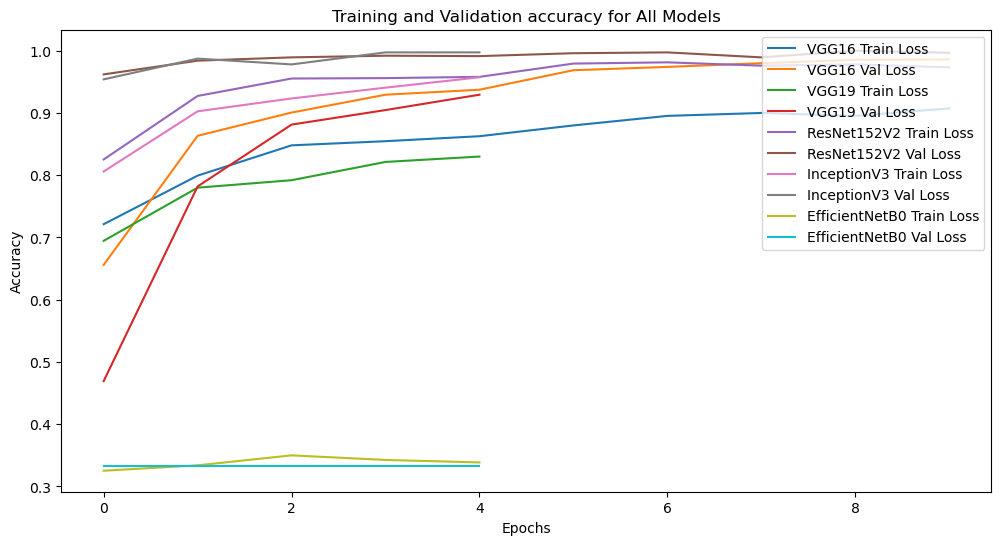

In [12]:
model_1st_trainer.train_and_evaluate_all_models()

Training VGG16...
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6788 - loss: 0.6181
Epoch 1: val_accuracy improved from -inf to 0.67500, saving model to model_2nd_checkpoint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.6797 - loss: 0.6177 - val_accuracy: 0.6750 - val_loss: 0.5597 - learning_rate: 0.0010
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7756 - loss: 0.4973
Epoch 2: val_accuracy improved from 0.67500 to 0.70000, saving model to model_2nd_checkpoint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.7760 - loss: 0.4968 - val_accuracy: 0.7000 - val_loss: 0.5405 - learning_rate: 0.0010
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8535 - loss: 0.3502
Epoch 3: val_accuracy improved from 0.70000 to 0.87500, saving model to model_2nd_checkpoint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8533 - loss: 0.3505 - val_accuracy: 0.8750 - val_loss: 0.4394 - learning_rate: 0.0010
Epoch 4/10
63/63 ━━

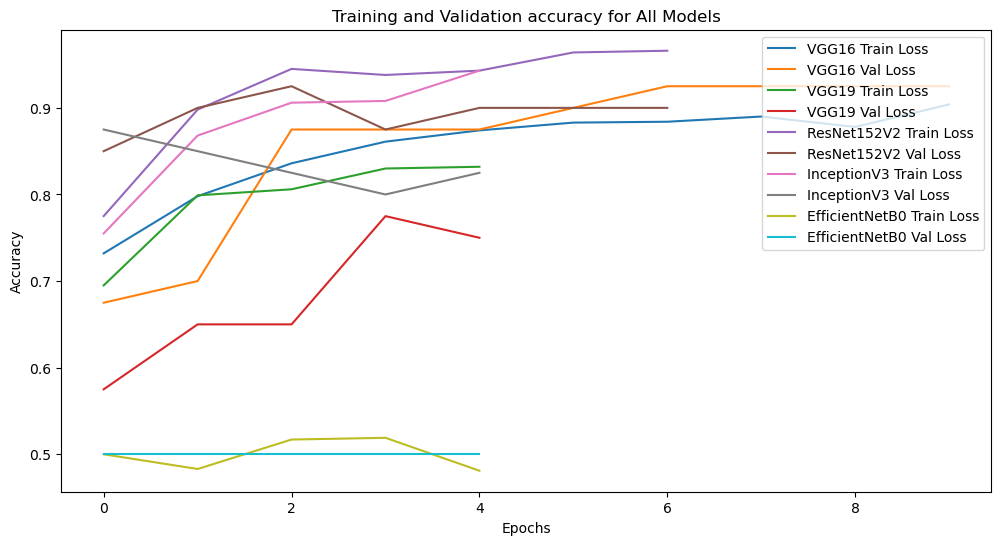

In [13]:
model_2nd_trainer.train_and_evaluate_all_models()